In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [15]:
df = pd.read_csv("clutch_events.csv")

#print(df.shape)
#print(df.head())


In [16]:
y = df["clutch_success"]

drop_cols = [
    "clutch_success", 
    "clutch_kills",    
    "demo_file",       
    "map",            
    "player_name", 
    "steamid64"
]

drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (1616, 20) Test size: (405, 20)


In [18]:
# Separate numerical & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical:", num_features)
print("Categorical:", cat_features)

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


Numerical: ['round', 'start_tick', 'start_time_s', 'time_left_s', 'start_vs', 'teammates_alive', 'enemies_alive', 'player_hp', 'player_armor', 'has_helmet', 'has_kit', 'player_equip_value', 'enemy_equip_value', 'bomb_planted', 'time_since_plant_s', 'round_end_reason']
Categorical: ['side', 'plant_site', 'weapon', 'round_winner_side']


In [19]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['round',
                                                                          'start_tick',
                                                                          'start_time_s',
                                                                          'time_left_s',
                                                                          'start_vs',
                                                                          'teammates_alive',
                                                                          'enemies_alive',
                                                                          'player_hp',
                                                                          'player_armor',
                                                                          'has_helmet',
                                                                          'has_kit',
                                                                          'player_equip_value',
                                                                          'enemy_equip_value',
                                                                          'bomb_planted',
                                                                          'time_since_plant_s',
                                                                          'round_end_...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                       0.3],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='recall', verbose=2)

In [20]:
best_xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb, zero_division=0))


Best XGBoost Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00        24

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405



In [21]:
from sklearn.model_selection import cross_val_score

best_xgb_model = grid_search_xgb.best_estimator_

# 5-fold CV on entire dataset
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='f1')

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean(), "±", cv_scores.std())


C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-validation F1 scores: [0.97959184 0.9787234  1.         1.         1.        ]
Mean F1: 0.9916630481980026 ± 0.01021433137901669


C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


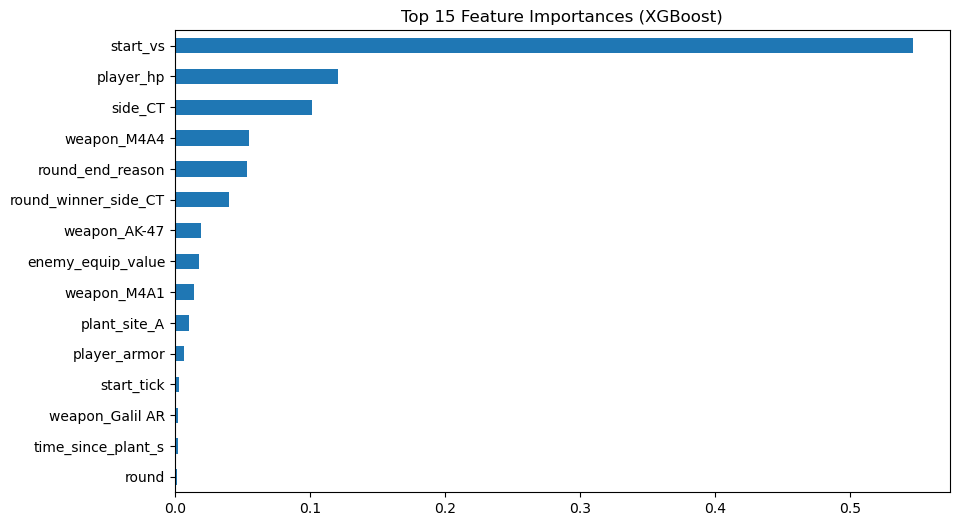

In [22]:
feature_names = (
    num_features +
    list(best_xgb_model.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

# extract importances
importances = best_xgb_model.named_steps["classifier"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 15
top_n = 15
plt.figure(figsize=(10,6))
feat_imp[:top_n].plot(kind="barh")
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


### 1. **Start_vs (Starting Advantage)**
- The strongest predictor by far.  
- Captures how many enemies the clutching player faces at the start (e.g., 1v1 vs 1v4).  
- Fewer enemies dramatically increase clutch probability.  

---

### 2. **Player HP**
- The second most influential feature.  
- More health = more margin for taking duels and surviving utility damage.  
- A low-HP player has much lower odds, regardless of weapons.  

---

### 3. **Side (CT or T)**
- The side the clutching player is on matters.  
- CT clutches often involve retakes, while T clutches may rely on bomb plant situations.  
- Reflects structural differences in how each side approaches late-round play.  

---

### 4–6. **Weapons (M4A4, AK-47, M4A1)**
- Weapon quality strongly influences clutch outcomes.  
- Rifles like M4 and AK appear consistently in successful clutches.  
- Indicates that access to reliable rifles is a key enabler.  

---

### 7–8. **Round Context (Round End Reason, Round Winner Side)**
- Certain round dynamics (e.g., defuse vs elimination) provide useful signals.  
- Helps the model recognize clutchable scenarios versus unwinnable ones.  

---

### 9. **Enemy Equipment Value**
- Still relevant, but not as decisive as player count and HP.  
- Suggests that numbers and health outweigh pure economy in shaping clutch odds.  

---

### 10–15. **Other Contributing Factors**
- **Plant site**: Location of the bomb affects angles and timing.  
- **Armor / Helmet**: Adds survivability in duels.  
- **Round progression (tick, time since plant, round number)**: Provides additional context, though less impactful compared to raw survival stats.  

---

- The model highlights **survival fundamentals (player count, HP, side)** as the **core clutch drivers**.  
- **Equipment (weapons, armor, utility)** still matters but plays a supporting role.  
- **Contextual features** like plant site, timing, and round dynamics add nuance but don’t outweigh the basics.  

In short: clutches are most winnable when you’re **in a low-enemy situation (1v1/1v2), healthy, and equipped with a strong rifle**, with side and round context shaping the finer details.  


In [23]:
import joblib

joblib.dump(best_xgb_model, "cs2_clutch_xgb.pkl")

print("Model saved as cs2_clutch_xgb.pkl")


Model saved as cs2_clutch_xgb.pkl
